In [35]:
import json
import numpy as np
import pandas as pd
import lxml

# Import SAP data from 15 December 2021

In [36]:
sap_data=pd.read_csv('data/SAP_15Dec21.csv')
sap_data['BaseDate'] = pd.to_datetime(sap_data['BaseDate'], format='%Y-%m-%d')

/tmp/ipykernel_20337/3562322008.py:1: DtypeWarning: Columns (2,3,4,8,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sap_data=pd.read_csv('data/SAP_15Dec21.csv')


In [37]:
mask = ((sap_data['Cases'] < 0))
try1 = sap_data[mask]
len(try1)
#try1['ActivityType'].unique()
#sap_data['ActivityType'].mask(mask,'5TRADERETURNS',inplace=True)

67701

In [38]:
mask = ((sap_data['Cases'] < 0)  & (sap_data['ActivityType'] == '2PLAN'))
try1=sap_data[mask]
print('2PLAN: ' + str(len(try1['Order Number'].unique())) + ' orders, with ' + str(len(try1)) + ' order lines')
mask = ((sap_data['Cases'] < 0)  & (sap_data['ActivityType'] == '3DESPATCH'))
try1=sap_data[mask]
print('3DESPATCH: ' + str(len(try1['Order Number'].unique())) + ' orders, with ' + str(len(try1)) + ' order lines')
mask = ((sap_data['Cases'] < 0)  & (sap_data['ActivityType'] == '4SETTLE'))
try1=sap_data[mask]
print('4SETTLE: ' + str(len(try1['Order Number'].unique())) + ' orders, with ' + str(len(try1)) + ' order lines')

2PLAN: 8092 orders, with 21342 order lines
3DESPATCH: 9022 orders, with 22969 order lines
4SETTLE: 9260 orders, with 23390 order lines


In [39]:
sap_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918658 entries, 0 to 918657
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            918658 non-null  int64         
 1   ActivityType          918658 non-null  object        
 2   Order Number          918658 non-null  object        
 3   Shipment N            918658 non-null  object        
 4   Delivery N            918658 non-null  object        
 5   DocumentNo            918658 non-null  object        
 6   Plant_Type            918658 non-null  object        
 7   Plant_WAREHOUSE_NAME  918658 non-null  object        
 8   Customer N            918658 non-null  object        
 9   Customer Name         918658 non-null  object        
 10  Billing Do            918658 non-null  object        
 11  Bill I                914493 non-null  object        
 12  Description           918658 non-null  object        
 13 

In [40]:
mask = ((sap_data['BaseHour'] == 12) & (sap_data['ActivityType'] == '3DESPATCH'))
temp1 = sap_data[mask]

In [41]:
len(temp1['Delivery N'].unique())

484

In [42]:
temp3 = temp1.groupby('Plant_WAREHOUSE_NAME')['Delivery N'].nunique()

In [43]:
temp3

Plant_WAREHOUSE_NAME
Bloemfontein_Gutche           2
Devland                       5
LDP Bloemfontein              3
LDP Evaton                    1
LDP Ga-rankuwa                1
LDP Makhado                   9
LDP Mankweng                 33
LDP Mbombela                  7
LDP Modjadji 2                5
LDP Osizweni                 58
LDP Pretoria east             7
LDP STANDERTON               15
LDP Tembisa west              2
LDP Ulundi                    2
LDP Vaal                      8
MLP DSD Benrose               2
MLP DSD Centurion            20
MLP DSD Edendale             49
MLP DSD Harrismith           26
MLP DSD Krugersdorp North    41
MLP DSD Molweni              88
MLP DSD Richards Bay         19
MLP DSD Sandton              27
Perseverance                  2
Phoenix                      34
Polokwane                     6
Premier Place                 5
Pretoria West                 7
Name: Delivery N, dtype: int64

In [44]:
temp3.to_excel('temp3.xlsx')

# Warehouse lookup table

### Start with a manually prepared table mapping D365 warehouses to the 88 SAP warehouses in the 15 Dec 21 data set

In [45]:
SAP_to_D365_warehouse=pd.read_csv('data/raw_data/warehouses/SAP-to-D365 warehouse mapping.csv')

In [46]:
SAP_to_D365_warehouse.drop(columns={'D365_Del_Loc', 'WAREHOUSELOCATIONID', 'site_id'}, inplace=True, axis=1)

### Merge with IPT_Site_Warehouse_locations to get SITE, WAREHOUSELOCATIONID, Cost Centre Financial Dimension and Financial Dimension for Stock Journal

In [47]:
IPT_Site_Warehouse_locations=pd.read_csv('data/raw_data/warehouses/IPT_Site_Warehouse_locations_20221226.csv')
#IPT_Site_Warehouse_locations=pd.read_csv('data/warehouses.csv')

In [48]:
IPT_Site_Warehouse_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   SITE                                   88 non-null     object
 1   WAREHOUSEID                            88 non-null     object
 2   WAREHOUSELOCATIONID                    88 non-null     object
 3   Cost Centre Financial Dimension        88 non-null     object
 4   Financial Dimension for Stock Journal  88 non-null     object
dtypes: object(5)
memory usage: 3.6+ KB


In [49]:
warehouses = pd.merge(
    SAP_to_D365_warehouse,
    IPT_Site_Warehouse_locations,
    how="inner",
    on=None,
    left_on='D365_WH_NO',
    right_on='WAREHOUSEID',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [50]:
warehouses.drop(columns={'WAREHOUSEID'}, inplace=True, axis=1)

In [51]:
warehouses.rename(columns={'Cost Centre Financial Dimension': 'Cost_Centre', 'Financial Dimension for Stock Journal':'Financial_Dimension'}, inplace=True)

In [52]:
warehouses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SAP_WH_NAME          88 non-null     object
 1   D365_WH_NAME         88 non-null     object
 2   D365_WH_NO           88 non-null     object
 3   SITE                 88 non-null     object
 4   WAREHOUSELOCATIONID  88 non-null     object
 5   Cost_Centre          88 non-null     object
 6   Financial_Dimension  88 non-null     object
dtypes: object(7)
memory usage: 5.5+ KB


### Merge with CE warehouses to get the CE Delivery Location

In [54]:
CE_IPT_Active_Warehouses=pd.read_excel('data/raw_data/warehouses/CE_IPT_Active Warehouses _DeliveryLocations_20221223.xlsx',sheet_name='CE Active Warehouses')


In [55]:
CE_IPT_Active_Warehouses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Warehouse Id                   1200 non-null   object
 1   Delivery Location Description  1200 non-null   object
 2   Description                    1200 non-null   object
dtypes: object(3)
memory usage: 28.2+ KB


In [56]:
warehouses = pd.merge(
    warehouses,
    CE_IPT_Active_Warehouses,
    how="inner",
    on=None,
    left_on='D365_WH_NO',
    right_on='Warehouse Id',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [57]:
warehouses.drop(columns={'Warehouse Id','Description'}, inplace=True, axis=1)

In [58]:
warehouses.rename(columns={'Delivery Location Description': 'D365_Del_Loc','SITE': 'site_id'}, inplace=True)

Change notes: 8 Jan
The following fields were in the warehouses dataframe before making these changes
    SAP_WH_NAME,D365_WH_NO,D365_WH_NAME,D365_Del_Loc,site_id,WAREHOUSELOCATIONID

The following fields were added (to be used in the journal creation):
    Cost_Centre, Financial_Dimension

In [59]:
warehouses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SAP_WH_NAME          88 non-null     object
 1   D365_WH_NAME         88 non-null     object
 2   D365_WH_NO           88 non-null     object
 3   site_id              88 non-null     object
 4   WAREHOUSELOCATIONID  88 non-null     object
 5   Cost_Centre          88 non-null     object
 6   Financial_Dimension  88 non-null     object
 7   D365_Del_Loc         88 non-null     object
dtypes: object(8)
memory usage: 6.2+ KB


# These are the required fields for warehouses
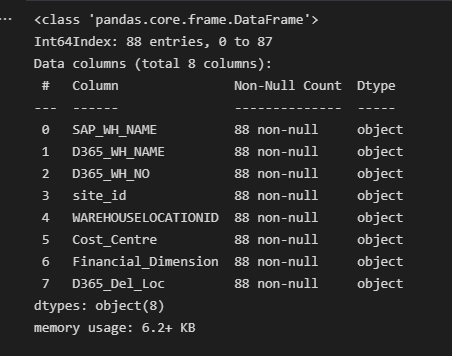

# Items lookup table

In [60]:
items=pd.read_csv('data/matched_items.csv')
items.rename(columns={'ITEMNUMBER': 'D365_ItemNo'}, inplace=True)

In [61]:
mask = (items['D365_ItemNo'].str.contains('CN'))

In [62]:
len(items[mask])

8

# Customers
- Use the Bloem customers list that Andre provided.
- Correlate with CE customers that are Outlets. Use CE_IPT_SoftDrinkOutlets_20200104.xlsx for this.
- Include only direct customers.  Get this from the customer master.
- Inner join this with the Bloem customers to get a list of Bloem customers (that we know will work), that also meet the criteria above.
- Do a random match for each valid SAP_15Dec21 customer to a Bloem customer.  There will be more than one SAP customer that will be mapped to a Bloem customer.
- We do not use Mode of Delivery from the customer master.
-'Source Channel' field to be defaulted to 'Voice In'
-'Order Category' field to be defaulted to 'Sales Local'

### Import the D365 customer master

In [63]:
customers=pd.read_csv('data/customer_master.csv')
# customers_short is just a copy of customers, without most of the columns
customers_short = customers[['ADDRESSZIPCODE','CUSTOMERACCOUNT','ORGANIZATIONNAME', 'NAMEALIAS', 'CCBCUSTOMERTYPE']].copy()

/tmp/ipykernel_20337/3652185213.py:1: DtypeWarning: Columns (6,18,58,95,104,117,148) have mixed types. Specify dtype option on import or set low_memory=False.
  customers=pd.read_csv('data/customer_master.csv')


### Fix the address zip code for later use

In [64]:
customers_short['ADDRESSZIPCODE'] = customers_short['ADDRESSZIPCODE'].fillna(0)
customers_short['ADDRESSZIPCODE'] = customers_short['ADDRESSZIPCODE'].astype(int)
customers_short['ADDRESSZIPCODE'] = customers_short['ADDRESSZIPCODE'].astype(str)

### Import the list of D365 Pilot customers (Bloem)

In [65]:
pilot_customers=pd.read_csv('data/Pilot Customer Accounts.csv')
pilot_customers['Account Number']=pilot_customers['Account Number'].astype(str)
pilot_customers.drop(columns={'Customer Category', 'Inv-Postal Code', 'Inv-Province', 'Inv-Suburb', 'Inv-City', 'Inv-Address 1', 'Inv-Address 2', 'BillTo LocationId'}, inplace=True, axis=1)


In [66]:
pilot_customers['Account Number'] = pilot_customers['Account Number'].astype(int)

In [67]:
pilot_customers.drop(columns={'Account Name'}, inplace=True, axis=1)

### Now import CE customers (provided by Gary on 7 Jan), and join that with pilot_customers to arrive at the list pf usable customers.

In [68]:
#outlet_customers = pd.read_excel('data/CE_IPT_SoftDrinkOutlets_20200104.xlsx')

# This new list was provided by Gary on 4 Jan @ 17h32.  
# [17:32] Gary Cook
# Wikus Olivier (Guest) Here is a new list of Pilot Accounts with a Soft Drink Product Policy that are not restricted on placing orders
# SoftDrinkOutlets_IPT.xlsx

#outlet_customers = pd.read_excel('data/SoftDrinkOutlets_IPT.xlsx')
outlet_customers = pd.read_excel('data/PilotAccounts.xlsx')


In [69]:
outlet_customers = outlet_customers.drop_duplicates()

In [70]:
outlet_customers.info(verbose=True,show_counts=True)
#outlet_customers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 1140
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Account Number            1141 non-null   int64 
 1   Account Name              1141 non-null   object
 2   CIC Order Placement Rule  220 non-null    object
dtypes: int64(1), object(2)
memory usage: 35.7+ KB


In [71]:
outlet_customers.rename(columns={'Account Name': 'D365_Account_Name'}, inplace=True)

In [72]:
pilot_customers = pd.merge(
    outlet_customers,
    pilot_customers,
    how="inner",
    on=None,
    left_on='Account Number',
    right_on='Account Number',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [73]:
pilot_customers.info()
#pilot_customers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 1140
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Account Number            1141 non-null   int64 
 1   D365_Account_Name         1141 non-null   object
 2   CIC Order Placement Rule  220 non-null    object
dtypes: int64(1), object(2)
memory usage: 35.7+ KB


### Change made on 9 Jan 2023

Change the “Source Channel” based on the following rules 
- Set to B2B if the “Bill I” column in Tommys data is B2B 
- Set to SFA if the “Bill I” column in Tommys data is HHT 
- Set to Voice in for all other rows 

The B2B order lines can only be linked to a B2B customer and the SFA and Voice In order lines should be linked to non B2B customers. 
- Gary has provided a new list of pilot accounts, with the Place Rule Columns (B2B or Blank).  This list also excludes customers with very low credit limits, which has cause submission holds on some on the FnO Prep Data.
- These changes only need to be made for the 1ORDERCREATION order lines/files 
- This will mean we can split the order creation between the 3 different channels/test cases 

In [74]:
sap_data['Source Channel'] = 'Voice in'

In [75]:
mask = ((sap_data['Bill I'] == 'B2B') & (sap_data['ActivityType'] == '1ORDERCREATION'))
sap_data['Source Channel'].mask(mask,'B2B',inplace=True)
mask = ((sap_data['Bill I'] == 'HHT') & (sap_data['ActivityType'] == '1ORDERCREATION'))
sap_data['Source Channel'].mask(mask,'SFA',inplace=True)

In [76]:
sap_data['Order Category'] = 'Sales Local'

### This section creates a list of customers, padding the SAP customers with a repeating list of allowable D365 customers
- For B2B customers, make sure they are aligned with those SAP customers for 1ORDERCREATION activity type
- First map the D365 B2B customers (CIC Order Placement Rule == B2B) to the unique list of SAP customers where Activity Type == 1ORDERCREATION
- Then extract the list of unique SAP customers for all lines where Activity Type != 1ORDERCREATION, remove those that have already been mapped, and map the rest to D365 customers that are non-B2B

In [77]:
# Extract a list of unique customers from the SAP data, where 'Source Channel' == 'B2B'
mask = (sap_data['Source Channel'] == 'B2B') 
try1 = sap_data[mask]
unique_SAP_customers_np = try1['Customer Name'].unique()
unique_SAP_customers1 = pd.DataFrame(unique_SAP_customers_np)
#unique_SAP_customers.to_csv('output/unique_sap_customers.csv')

In [78]:
unique_SAP_customers1.rename(columns={0: 'SAP_Cust_Name'}, inplace=True)

In [79]:
# Extract  list of allowable pilot customers, where CIC Order Placement Rule = B2B
mask = (pilot_customers['CIC Order Placement Rule'] == 'B2B') 
try1 = pilot_customers[mask]
allowable_pilot_customers_np = try1['Account Number'].unique()
allowable_pilot_customers = pd.DataFrame(allowable_pilot_customers_np)

In [80]:
repeats = int(len(unique_SAP_customers_np)/len(allowable_pilot_customers_np) + 1)

In [81]:
new_array = allowable_pilot_customers_np.repeat(repeats)

In [82]:
trim_rows = len(new_array) - len(unique_SAP_customers_np)

In [83]:
#a[:-n, :]
trimmed_array = new_array[:-trim_rows :]

In [84]:
unique_SAP_customers1['D365_Cust_No'] = trimmed_array.tolist()

In [85]:
# Repeat the process, but now with the rest of the activity types, mapping to the remainder of the D365 customers

# Extract a list of unique customers from the SAP data, where 'Source Channel' != 'B2B'
mask = (sap_data['Source Channel'] != 'B2B')
try1 = sap_data[mask]
unique_SAP_customers_np = try1['Customer Name'].unique()
unique_SAP_customers2 = pd.DataFrame(unique_SAP_customers_np)

unique_SAP_customers2.rename(columns={0: 'SAP_Cust_Name'}, inplace=True)

In [86]:
# Now exclude those SAP customers that have already been mapped to a D365 customer.  To do that, join the two dataframes
unique_SAP_customers2 = pd.merge(
    unique_SAP_customers2,
    unique_SAP_customers1,
    how="left",
    on=None,
    left_on='SAP_Cust_Name',
    right_on='SAP_Cust_Name',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [87]:
mask = (unique_SAP_customers2['D365_Cust_No'].isna())
unique_SAP_customers2 = unique_SAP_customers2[mask]

In [88]:
# Extract  list of allowable pilot customers, where CIC Order Placement Rule != B2B
mask = (pilot_customers['CIC Order Placement Rule'] != 'B2B') 
try1 = pilot_customers[mask]
allowable_pilot_customers_np = try1['Account Number'].unique()
allowable_pilot_customers2 = pd.DataFrame(allowable_pilot_customers_np)

repeats = int(len(unique_SAP_customers2)/len(allowable_pilot_customers_np) + 1)
new_array = allowable_pilot_customers_np.repeat(repeats)
trim_rows = len(new_array) - len(unique_SAP_customers2)
trimmed_array = new_array[:-trim_rows :]
unique_SAP_customers2['D365_Cust_No'] = trimmed_array.tolist()

In [89]:
# Concatenate unique_SAP_customers1 and unique_SAP_customers2
unique_SAP_customers = pd.concat([unique_SAP_customers1, unique_SAP_customers2], ignore_index=True)

In [90]:
len(sap_data['Customer Name'].unique())

23687

In [91]:
# Merge to pull in the rest of the columns in "pilot_customers"
unique_SAP_customers = pd.merge(
    unique_SAP_customers,
    pilot_customers,
    how="inner",
    on=None,
    left_on='D365_Cust_No',
    right_on='Account Number',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [92]:
unique_SAP_customers.drop(columns={'Account Number'}, inplace=True, axis=1)

In [93]:
#unique_SAP_customers['Source Channel'] = 'Voice In'
#unique_SAP_customers['Order Category'] = 'Sales Local'

In [94]:
unique_SAP_customers['CIC Order Placement Rule'].unique()

array([nan, 'B2B'], dtype=object)

### Join SAP_15Dec data with D365 items

In [95]:
# Make a new dataframe for the SAP data
sap_data_orders = sap_data[['ActivityType', 'Order Number', 'Plant_WAREHOUSE_NAME', 'Customer N', 'Customer Name', 'Material No', 'Material Description', 'BaseDate', 'BaseHour', 'Cases','Bill I','Source Channel','Order Category']]

In [96]:
# Only filter out type 'AP'
mask = (sap_data_orders['ActivityType'] != 'AP')
sap_data_orders = sap_data_orders[mask]
#sap_data_orders.drop(columns={'Cases'}, inplace=True, axis=1)
sap_data_orders.rename(columns={'Plant (WAREHOUSE NAME)': 'SAP_WH', 'Material No': 'SAP_MatlNo'}, inplace=True)


In [97]:
# New code for updating "Cases".  Where Cases==0, assign a fixed quantity of 10.  Where Cases<0, negate the quantity.
mask = (sap_data_orders['Cases'] == 0) 
sap_data_orders['Cases'].mask(mask,10,inplace=True)

mask = (sap_data_orders['Cases'] < 0) 
sap_data_orders['Cases'].mask(mask,-sap_data_orders['Cases'],inplace=True)

In [98]:
df3 = pd.merge(
    sap_data_orders,
    items,
    how="inner",
    on=None,
    left_on='Material Description',
    right_on='Material_Description',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [99]:
df3.drop(columns={'Material Description', 'SAP_MatlNo'}, inplace=True, axis=1)

In [100]:
df3['ActivityType'].unique()

array(['2PLAN', '3DESPATCH', '4SETTLE', '1ORDERCREATION'], dtype=object)

In [101]:
df3['MOD'] = ''

In [102]:
# Now default Mode of Delivery accourding to ActivityType
mask = (df3['ActivityType'] == '1ORDERCREATION') 
df3['MOD'].mask(mask,'01',inplace=True)
mask = (df3['ActivityType'] == '2PLAN') 
df3['MOD'].mask(mask,'02',inplace=True)
mask = (df3['ActivityType'] == '3DESPATCH') 
df3['MOD'].mask(mask,'03',inplace=True)
mask = (df3['ActivityType'] == '4SETTLE') 
df3['MOD'].mask(mask,'04',inplace=True)
mask = (df3['ActivityType'] == '5TRADERETURNS') 
df3['MOD'].mask(mask,'05',inplace=True)

### Join SAP data with Warehouse

In [103]:
df4 = pd.merge(
    df3,
    warehouses,
    how="inner",
    on=None,
    left_on='Plant_WAREHOUSE_NAME',
    right_on='SAP_WH_NAME',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [104]:
df4.drop(columns={'SAP_WH_NAME', 'Plant_WAREHOUSE_NAME', 'SAP_WH_NAME', 'D365_WH_NO', 'D365_WH_NAME'}, inplace=True, axis=1)

In [105]:
# Used this code once only to extract a unique list of SAP customer names
# SAP_customers = df4['Customer Name'].unique()
# pd.DataFrame(SAP_customers).to_csv('output/SAP_customers.csv')

### Merge SAP data with Customer lookup table
Note that there is no logic in replacing SAP customers with D365 customers, as only Bloem customers are available for the performance test.  

In [106]:
df5 = pd.merge(
    df4,
    unique_SAP_customers,
    how="inner",
    on=None,
    left_on='Customer Name',
    right_on='SAP_Cust_Name',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [107]:
df5.drop(columns={'Customer N','Customer Name','SAP_Cust_Name'}, inplace=True, axis=1)

In [108]:
df5['Order Number'] = df5['Order Number'].astype(int)

In [109]:
df5.drop_duplicates(subset=['ActivityType', 'Order Number', 'D365_ItemNo'],keep='first',inplace=True)

In [110]:
df5.drop(columns={'Cost_Centre', 'Financial_Dimension'}, inplace=True, axis=1)

In [111]:
df5['Bill I'].unique()

array(['ZRCR', 'ZFBO', 'ZFBR', 'HHT', nan, 'ZFRO', 'ZPLS', 'ZCOR', 'CRM',
       'ZTRD', 'ZTRR', 'ZUBR', 'ZPLR', 'ZCOS', 'ZFBF', 'ZFRE', 'CRMW',
       'ZUBS', 'ZRCS', 'ZLC', 'B2B', 'ZMTC'], dtype=object)

In [112]:
""" mask = ((df5['Bill I'] == 'B2B') & (df5['ActivityType'] == '1ORDERCREATION'))
df5['Source Channel'].mask(mask,'B2B',inplace=True)
mask = ((df5['Bill I'] == 'HHT') & (df5['ActivityType'] == '1ORDERCREATION'))
df5['Source Channel'].mask(mask,'SFA',inplace=True) """
# The rest of the records are already set to "Voice in"

" mask = ((df5['Bill I'] == 'B2B') & (df5['ActivityType'] == '1ORDERCREATION'))\ndf5['Source Channel'].mask(mask,'B2B',inplace=True)\nmask = ((df5['Bill I'] == 'HHT') & (df5['ActivityType'] == '1ORDERCREATION'))\ndf5['Source Channel'].mask(mask,'SFA',inplace=True) "

In [113]:
temp6 = pd.DataFrame(df5['D365_Cust_No'].unique())

In [114]:
temp6.to_excel('temp6.xlsx')

In [115]:
#mask = (df5['D365_ItemNo'].str.contains('CN'))

In [116]:
temp=df5[mask]

/tmp/ipykernel_20337/1579820086.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp=df5[mask]


In [117]:
temp['D365_ItemNo'].unique()

array([], dtype=object)

### Generate output files

In [119]:
# Generate CSV for the entire SAP data set
df5.to_csv('output/15Dec_D365_orders.csv', index=False)

In [120]:
# Now drop lines with negative order quantities, except where ActivityType = 5TRADERETURNS
#mask = ((df5['Cases'] > 0) | (df5['ActivityType'] == '5TRADERETURNS'))
#df5 = df5[mask]

In [121]:
mask = ((df5['ActivityType'] == '1ORDERCREATION') &  (df5['BaseHour'] == 12) & (df5['Bill I'] == 'HHT'))

In [122]:
temp1 = df5[mask]

In [123]:
len(temp1['Order Number'].unique())

1268

In [124]:
# Generate CSVs per activity type, and for the 13th and 20th hours
# 1ORDERCREATION
mask = ((df5['ActivityType'] == '1ORDERCREATION') &  (df5['BaseHour'] == 12))
peak_order_hour = df5[mask]
peak_order_hour.to_csv('output/15Dec_D365_orders_1ORDERCREATION_12h.csv',index=False)

mask = ((df5['ActivityType'] == '1ORDERCREATION') &  (df5['BaseHour'] == 19))
peak_settlement_hour = df5[mask]
peak_settlement_hour.to_csv('output/15Dec_D365_orders_1ORDERCREATION_19h.csv',index=False)

# 2PLAN
mask = ((df5['ActivityType'] == '2PLAN') &  (df5['BaseHour'] == 12))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_2PLAN_12h.csv',index=False)

mask = ((df5['ActivityType'] == '2PLAN') &  (df5['BaseHour'] == 19))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_2PLAN_19h.csv',index=False)

# 3DESPATCH
mask = ((df5['ActivityType'] == '3DESPATCH') &  (df5['BaseHour'] == 12))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_3DESPATCH_12h.csv',index=False)

mask = ((df5['ActivityType'] == '3DESPATCH') &  (df5['BaseHour'] == 19))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_3DESPATCH_19h.csv',index=False)

# 4SETTLE
mask = ((df5['ActivityType'] == '4SETTLE') &  (df5['BaseHour'] == 12))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_4SETTLE_12h.csv',index=False)

mask = ((df5['ActivityType'] == '4SETTLE') &  (df5['BaseHour'] == 19))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_4SETTLE_19h.csv',index=False)

# 5TRADERETURNS
mask = ((df5['ActivityType'] == '5TRADERETURNS') &  (df5['BaseHour'] == 12))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_5TRADERETURNS_12h.csv',index=False)

mask = ((df5['ActivityType'] == '5TRADERETURNS') &  (df5['BaseHour'] == 19))
df5_1 = df5[mask]
df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
df5_1.to_csv('output/15Dec_D365_orders_5TRADERETURNS_19h.csv',index=False)

/tmp/ipykernel_20337/2200613148.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
/tmp/ipykernel_20337/2200613148.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_1.drop(columns={'CIC Order Placement Rule'}, inplace=True, axis=1)
/tmp/ipykernel_20337/2200613148.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_1.drop(columns={'CIC Order Placement R

In [125]:
peak_order_hour['Source Channel'].unique()

array(['SFA', 'Voice in', 'B2B'], dtype=object)

In [126]:
# Generate a CSV for the rest of the hours, that is, excluding the 13th and 20th hours.  This set can be used to do preparation testing.
mask = ((df5['BaseHour'] != 12) & (df5['BaseHour'] != 19))
df5_1 = df5[mask]
df5_1.to_csv('output/15Dec_D365_orders_excluding_12h_19h.csv', index=False)

In [127]:
len(df5_1['D365_Cust_No'].unique())

1099

In [128]:
#From above, generate a file that contains just one record per customer, so that we can use this to verify that each customer master record works
df5_1.drop_duplicates(subset=['D365_Cust_No'],keep='first',inplace=True)

/tmp/ipykernel_20337/2635724467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_1.drop_duplicates(subset=['D365_Cust_No'],keep='first',inplace=True)


In [129]:
df5_1.to_csv('output/15Dec_D365_single_line_per_customer_excluding_12h_19h.csv', index=False)

### Calculate order volumes per cycle

In [130]:
try2 = peak_order_hour.loc[peak_order_hour['Source Channel'] == 'SFA']
SFA_order_lines12h = len(try2)
SFA_orders12h = len(try2['Order Number'].unique())

try2 = peak_order_hour.loc[peak_order_hour['Source Channel'] == 'Voice In']
VoiceIn_order_lines12h = len(try2)
VoiceIn_orders12h = len(try2['Order Number'].unique())

try2 = peak_order_hour.loc[peak_order_hour['Source Channel'] == 'B2B']
B2B_order_lines12h = len(try2)
B2B_orders12h = len(try2['Order Number'].unique())

try2 = peak_settlement_hour.loc[peak_settlement_hour['Source Channel'] == 'SFA']
SFA_order_lines19h = len(try2)
SFA_orders19h = len(try2['Order Number'].unique())

try2 = peak_settlement_hour.loc[peak_settlement_hour['Source Channel'] == 'Voice In']
VoiceIn_order_lines19h = len(try2)
VoiceIn_orders19h = len(try2['Order Number'].unique())

try2 = peak_settlement_hour.loc[peak_settlement_hour['Source Channel'] == 'B2B']
B2B_order_lines19h = len(try2)
B2B_orders19h = len(try2['Order Number'].unique())

print('SFA order lines for 12h-13h = '+str(SFA_order_lines12h))
print('SFA orders for 12h-13h = '+str(SFA_orders12h))
print('Voice In order lines for 12h-13h = '+str(VoiceIn_order_lines12h))
print('Voice In orders for 12h-13h = '+str(VoiceIn_orders12h))
print('B2B order lines for 12h-13h = '+str(B2B_order_lines12h))
print('B2B orders for 12h-13h = '+str(B2B_orders12h))
print('\nTOTAL order lines for 12h-13h = '+str(len(peak_order_hour)))

SFA order lines for 12h-13h = 20008
SFA orders for 12h-13h = 1268
Voice In order lines for 12h-13h = 0
Voice In orders for 12h-13h = 0
B2B order lines for 12h-13h = 19601
B2B orders for 12h-13h = 505

TOTAL order lines for 12h-13h = 43032


In [131]:
service_portal_percentage = 0.1
print('100% test cycle volumes:\n')
cycle_perc=1
print('SFA order lines for 12h-13h = '+str(round(SFA_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('Voice In order lines for 12h-13h = '+str(round(VoiceIn_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('B2B order lines for 12h-13h = '+str(round(B2B_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('Service order lines for 12h-13h = '+str(round((B2B_order_lines12h+VoiceIn_order_lines12h+SFA_order_lines12h)*service_portal_percentage*cycle_perc)))
print('TOTAL order lines for 12h-13h = '+str(round(len(peak_order_hour)*cycle_perc)))

print('')
print('SFA order lines for 19h-20h = '+str(round(SFA_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('Voice In order lines for 19h-20h = '+str(round(VoiceIn_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('B2B order lines for 19h-20h = '+str(round(B2B_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('Service order lines for 19h-20h = '+str(round((B2B_order_lines19h+VoiceIn_order_lines19h+SFA_order_lines19h)*service_portal_percentage*cycle_perc)))
print('TOTAL order lines for 19h-20h = '+str(round(len(peak_settlement_hour)*cycle_perc)))

100% test cycle volumes:

SFA order lines for 12h-13h = 18007
Voice In order lines for 12h-13h = 0
B2B order lines for 12h-13h = 17641
Service order lines for 12h-13h = 3961
TOTAL order lines for 12h-13h = 43032

SFA order lines for 19h-20h = 833
Voice In order lines for 19h-20h = 0
B2B order lines for 19h-20h = 38
Service order lines for 19h-20h = 97
TOTAL order lines for 19h-20h = 1158


In [132]:
print('10% test cycle volumes:\n')
cycle_perc=0.1
print('SFA order lines for 12h-13h = '+str(round(SFA_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('Voice In order lines for 12h-13h = '+str(round(VoiceIn_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('B2B order lines for 12h-13h = '+str(round(B2B_order_lines12h*(1-service_portal_percentage)*cycle_perc)))
print('Service order lines for 12h-13h = '+str(round((B2B_order_lines12h+VoiceIn_order_lines12h+SFA_order_lines12h)*service_portal_percentage*cycle_perc)))
print('TOTAL order lines for 12h-13h = '+str(round(len(peak_order_hour)*cycle_perc)))

print('')
print('SFA order lines for 19h-20h = '+str(round(SFA_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('Voice In order lines for 19h-20h = '+str(round(VoiceIn_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('B2B order lines for 19h-20h = '+str(round(B2B_order_lines19h*(1-service_portal_percentage)*cycle_perc)))
print('Service order lines for 19h-20h = '+str(round((B2B_order_lines19h+VoiceIn_order_lines19h+SFA_order_lines19h)*service_portal_percentage*cycle_perc)))
print('TOTAL order lines for 19h-20h = '+str(round(len(peak_settlement_hour)*cycle_perc)))

10% test cycle volumes:

SFA order lines for 12h-13h = 1801
Voice In order lines for 12h-13h = 0
B2B order lines for 12h-13h = 1764
Service order lines for 12h-13h = 396
TOTAL order lines for 12h-13h = 4303

SFA order lines for 19h-20h = 83
Voice In order lines for 19h-20h = 0
B2B order lines for 19h-20h = 4
Service order lines for 19h-20h = 10
TOTAL order lines for 19h-20h = 116


# Create file for stock journals

### Create a journal line item per item per warehouse, with a replenishment_qty that is 100x the sum of order quantities (Cases) per line

In [133]:
# Create this dataframe before dropping columns not needed for order creation
stock_journal = df5[['D365_ItemNo', 'D365_Del_Loc','Cases']]
stock_journal = stock_journal.groupby(['D365_Del_Loc', 'D365_ItemNo'],as_index=False).sum('Cases')

In [134]:
#stock_journal.info()

In [135]:
stock_journal['replenishment_qty'] = stock_journal['Cases']*100

### Merge with warehouse dataframe to get Financial Dimensions per warehouse

In [136]:
stock_journal['INVENTORYSTATUSID'] = 'Available'

In [137]:
stock_journal1 = pd.merge(
    stock_journal,
    warehouses,
    how="inner",
    on=None,
    left_on='D365_Del_Loc',
    right_on='D365_Del_Loc',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [138]:
#stock_journal1.info()

In [139]:
stock_journal1.rename(columns={'Financial_Dimension': 'DEFAULTLEDGERDIMENSIONDISPLAYVALUE'}, inplace=True)

In [140]:
stock_journal1.drop(columns={'Cases', 'D365_WH_NAME', 'SAP_WH_NAME','Cost_Centre'}, inplace=True, axis=1)

In [141]:
stock_journal1 = stock_journal1.sort_values(['D365_WH_NO'],ascending=True)

In [142]:
# Add a sequential index for LineNumber
line_number = range(1,stock_journal1.last_valid_index()+2,1)
stock_journal1['LINENUMBER']=line_number

### Generate a journal number per warehouse

In [143]:
journal_number = pd.DataFrame(stock_journal1['D365_WH_NO'].unique())

In [144]:
journal_number.rename(columns={0: 'D365_WH_NO'}, inplace=True)

In [145]:
journal_number = journal_number.sort_values(['D365_WH_NO'],ascending=True)

In [146]:
first_valid_jnumber = input('Enter first valid journal number (numbers only)')
#first_valid_jnumber = '76517'
first_valid_jnumber = int(first_valid_jnumber)
#ZA10700076636 - 24 Jan 2023

In [147]:
index = range(first_valid_jnumber,first_valid_jnumber+journal_number.last_valid_index()+1,1)
journal_number['JOURNALNUMBER']=index

In [148]:
journal_number['JOURNALNUMBER'] = journal_number['JOURNALNUMBER'].astype(str)
journal_number['JOURNALNUMBER'] = 'ZA107000' +  + journal_number['JOURNALNUMBER']
#journal_number['JOURNALNUMBER'] = journal_number['D365_WH_NO'].str.slice(0,4) + journal_number['JOURNALNUMBER']

In [149]:
stock_journal1 = pd.merge(
   stock_journal1,
   journal_number,
   how="inner",
   on=None,
   left_on='D365_WH_NO',
   right_on='D365_WH_NO',
   left_index=False,
   right_index=False,
   sort=True,
   suffixes=("_x", "_y"),
   copy=True,
   indicator=False,
   validate=None,
)

In [150]:
#stock_journal1.info()

In [151]:
stock_journal1['ITEMBATCHNUMBER']='1'
stock_journal1['JOURNALNAMEID']='ADJ_WHS'
stock_journal1['TRANSACTIONDATE']= pd.to_datetime('today').date()

In [152]:
stock_journal1.to_csv('output/stock_journal.csv',index=False)

# Analyze SAP data to find logic with Delivery N field

In [153]:
sap_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918658 entries, 0 to 918657
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            918658 non-null  int64         
 1   ActivityType          918658 non-null  object        
 2   Order Number          918658 non-null  object        
 3   Shipment N            918658 non-null  object        
 4   Delivery N            918658 non-null  object        
 5   DocumentNo            918658 non-null  object        
 6   Plant_Type            918658 non-null  object        
 7   Plant_WAREHOUSE_NAME  918658 non-null  object        
 8   Customer N            918658 non-null  object        
 9   Customer Name         918658 non-null  object        
 10  Billing Do            918658 non-null  object        
 11  Bill I                914493 non-null  object        
 12  Description           918658 non-null  object        
 13 

In [154]:
sap_data['delivery_order_check'] = sap_data['Delivery N'] == sap_data['Order Number']

In [155]:
mask = (sap_data['delivery_order_check'] == False)
sap_data2 = sap_data[mask]

In [156]:
sap_data2.drop_duplicates(subset=['Delivery N', 'Order Number'],keep='first',inplace=True)

/tmp/ipykernel_20337/3219347210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sap_data2.drop_duplicates(subset=['Delivery N', 'Order Number'],keep='first',inplace=True)


In [157]:
sap_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45721 entries, 0 to 918378
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            45721 non-null  int64         
 1   ActivityType          45721 non-null  object        
 2   Order Number          45721 non-null  object        
 3   Shipment N            45721 non-null  object        
 4   Delivery N            45721 non-null  object        
 5   DocumentNo            45721 non-null  object        
 6   Plant_Type            45721 non-null  object        
 7   Plant_WAREHOUSE_NAME  45721 non-null  object        
 8   Customer N            45721 non-null  object        
 9   Customer Name         45721 non-null  object        
 10  Billing Do            45721 non-null  object        
 11  Bill I                45424 non-null  object        
 12  Description           45721 non-null  object        
 13  Driver code    

In [158]:
sap_data_1 = sap_data.groupby(['ActivityType','Customer N','Order Number','Delivery N'],as_index=False).count()

In [159]:
sap_data_1

,ActivityType,Customer N,Order Number,Delivery N,Unnamed: 0,Shipment N,DocumentNo,Plant_Type,Plant_WAREHOUSE_NAME,Customer Name,...,Driver code,Driver Nam,Material No,Material Description,BaseDate,BaseHour,Cases,Source Channel,Order Category,delivery_order_check
0,1ORDERCREATION,247121,72443657,8083193769,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,1ORDERCREATION,247131,72445104,-,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1ORDERCREATION,247131,72445104,8083189838,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
3,1ORDERCREATION,247131,72445104,8083207441,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,1ORDERCREATION,247140,72447139,-,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85508,4SETTLE,799723,8083160218,8083160218,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
85509,4SETTLE,799731,72423560,8083157841,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
85510,4SETTLE,799731,8083160219,8083160219,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
85511,4SETTLE,C1000-1401,8083106039,8083106039,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [160]:
sap_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85513 entries, 0 to 85512
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ActivityType          85513 non-null  object
 1   Customer N            85513 non-null  object
 2   Order Number          85513 non-null  object
 3   Delivery N            85513 non-null  object
 4   Unnamed: 0            85513 non-null  int64 
 5   Shipment N            85513 non-null  int64 
 6   DocumentNo            85513 non-null  int64 
 7   Plant_Type            85513 non-null  int64 
 8   Plant_WAREHOUSE_NAME  85513 non-null  int64 
 9   Customer Name         85513 non-null  int64 
 10  Billing Do            85513 non-null  int64 
 11  Bill I                85513 non-null  int64 
 12  Description           85513 non-null  int64 
 13  Driver code           85513 non-null  int64 
 14  Driver Nam            85513 non-null  int64 
 15  Material No           85513 non-null

In [161]:
len(sap_data['Order Number'].unique())

44532

In [162]:
#sap_data_1.rename(columns={0:'A'}, inplace=True)

In [163]:
sap_data_1.drop(columns={'Unnamed: 0','BaseHour', 'Cases'}, inplace=True, axis=1)

In [164]:
len(sap_data_1['Delivery N'].unique())

57079

In [165]:
sap_data_1.drop_duplicates(subset=['Delivery N', 'Order Number'],keep='first',inplace=True)

In [166]:
sap_data2

,Unnamed: 0,ActivityType,Order Number,Shipment N,Delivery N,DocumentNo,Plant_Type,Plant_WAREHOUSE_NAME,Customer N,Customer Name,...,Driver code,Driver Nam,Material No,Material Description,BaseDate,BaseHour,Cases,Source Channel,Order Category,delivery_order_check
0,0,1ORDERCREATION,72441313,12704891,8083169544,-,LDP,LDP Acornhoek,247489,CHICKEN LICKEN ACORNHOEK MALL,...,-,-,C6207,FANTA ORANGE 01X24 440 PET,2021-12-15,11,0,Voice in,Sales Local,False
7,7,1ORDERCREATION,72443937,-,-,-,LDP,LDP Acornhoek,251521,SHOPRITE LIQUOR ACORNHOEK PLAZA,...,-,-,C1481,COKE NO SUGAR 01X24 500 SHR,2021-12-15,12,0,Voice in,Sales Local,False
41,41,1ORDERCREATION,72451646,12706815,8083188790,-,LDP,LDP Acornhoek,257264,CROSSROAD TUCK SHOP,...,-,-,C1040,COKE 01X06 2000 SHR,2021-12-15,17,0,SFA,Sales Local,False
50,50,1ORDERCREATION,72437580,12704891,8083169537,-,LDP,LDP Acornhoek,257635,GALITO'S ACORNHOEK,...,-,-,C1040,COKE 01X06 2000 SHR,2021-12-15,9,0,Voice in,Sales Local,False
56,56,1ORDERCREATION,72437580,12704891,8083191502,-,LDP,LDP Acornhoek,257635,GALITO'S ACORNHOEK,...,-,-,C6571,CAPPY MAN OR ST 04X06 330ML CAN,2021-12-15,9,0,Voice in,Sales Local,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918337,918338,4SETTLE,72430257,12702338,8083143873,-,LDP,MLP DSD Benrose,1113527,LOWCOST STORE,...,831452,1214 HC KA,C10194,STONEY 01X12 1250 RGBPL,2021-12-15,19,2,Voice in,Sales Local,False
918344,918345,4SETTLE,72429287,12702566,8083148469,-,LDP,MLP DSD Centurion,1514102,ENGEN QS CORNWALL VIEW,...,833232,1106 LDP F,C7516,FUZE LEMON 04X06 500 PET,2021-12-15,19,0,Voice in,Sales Local,False
918345,918346,4SETTLE,72429313,12702567,8083148468,-,LDP,MLP DSD Centurion,1515852,ENGEN QS GARSTKLOOF,...,832464,1106 HC KP,C7516,FUZE LEMON 04X06 500 PET,2021-12-15,20,0,Voice in,Sales Local,False
918346,918347,4SETTLE,72429019,12702338,8083141683,-,LDP,MLP DSD Benrose,773612,BRAAMFONTEIN SUPERMARKET,...,831452,1214 HC KA,C4307,BONAQUA PUMP STL 04X06 750 PET,2021-12-15,19,1,Voice in,Sales Local,False


In [167]:
sap_data2.to_csv('data/delivery_numbers.csv')

In [168]:
print(sap_data_1)

         ActivityType  Customer N Order Number  Delivery N  Shipment N  \
0      1ORDERCREATION      247121     72443657  8083193769           2   
1      1ORDERCREATION      247131     72445104           -           1   
2      1ORDERCREATION      247131     72445104  8083189838          54   
3      1ORDERCREATION      247131     72445104  8083207441           2   
4      1ORDERCREATION      247140     72447139           -           1   
...               ...         ...          ...         ...         ...   
85498         4SETTLE      796686    855215821   855215821           1   
85499         4SETTLE      796747   8083129716  8083129716           1   
85503         4SETTLE      799392     72418717  8083137971           1   
85511         4SETTLE  C1000-1401   8083106039  8083106039           2   
85512              AP           -            -           -         263   

       DocumentNo  Plant_Type  Plant_WAREHOUSE_NAME  Customer Name  \
0               2           2            